## Imports

In [1]:
from typing import List


%pylab inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk
import requests
import pandas_profiling as pp
import os
import graphviz
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.svm import SVC
# from pandas_profiling.utils.cache import cache_file

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

Populating the interactive namespace from numpy and matplotlib


---
# Load Data

## Constants

In [2]:
DATA_PATH = "https://raw.githubusercontent.com/Citoci/SpaceshipTitanic/master/data/"
OUTPUT_PATH = "/content/"
RANDOM_STATE = 3993

## Dataset

In [3]:
dataset = pd.read_csv(DATA_PATH + "train.csv")

# Save the target column and drop the target
target = dataset.Transported
dataset.drop(columns="Transported", inplace=True)

# Set the index
dataset.set_index('PassengerId', inplace=True)

# Sort columns by name
dataset.sort_index(axis="columns", inplace=True)

original_dataset = dataset.copy()

dataset

,Age,Cabin,CryoSleep,Destination,FoodCourt,HomePlanet,Name,RoomService,ShoppingMall,Spa,VIP,VRDeck
PassengerId,,,,,,,,,,,,
0001_01,39.0,B/0/P,False,TRAPPIST-1e,0.0,Europa,Maham Ofracculy,0.0,0.0,0.0,False,0.0
0002_01,24.0,F/0/S,False,TRAPPIST-1e,9.0,Earth,Juanna Vines,109.0,25.0,549.0,False,44.0
0003_01,58.0,A/0/S,False,TRAPPIST-1e,3576.0,Europa,Altark Susent,43.0,0.0,6715.0,True,49.0
0003_02,33.0,A/0/S,False,TRAPPIST-1e,1283.0,Europa,Solam Susent,0.0,371.0,3329.0,False,193.0
0004_01,16.0,F/1/S,False,TRAPPIST-1e,70.0,Earth,Willy Santantines,303.0,151.0,565.0,False,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9276_01,41.0,A/98/P,False,55 Cancri e,6819.0,Europa,Gravior Noxnuther,0.0,0.0,1643.0,True,74.0
9278_01,18.0,G/1499/S,True,PSO J318.5-22,0.0,Earth,Kurta Mondalley,0.0,0.0,0.0,False,0.0
9279_01,26.0,G/1500/S,False,TRAPPIST-1e,0.0,Earth,Fayey Connon,0.0,1872.0,1.0,False,0.0


---
# Global Data Analysis and Preprocessing

Defining some helper transformers

In [4]:
# used to sort the columns in a pipeline to avoid transforming problems
columns_sorter = FunctionTransformer(lambda ds: ds.sort_index(axis='columns'))

## Missing Values






### Helper functions for missing values

In [5]:
def count_missing(ds: pd.DataFrame):
    return ds.shape[0] - ds.count()

In [6]:
def get_sample_with_nans(ds: pd.DataFrame):
    return ds.loc[ds.isna().any(axis=1)]

In [7]:
sample_with_nans_ids = get_sample_with_nans(dataset).index

### Impute Missing Values

Helper function and relative transformer

In [8]:
def array_to_dataframe(arr: np.ndarray, columns: List[str]):
    return pd.DataFrame(data=arr, columns=columns)

# used to transform an array to a dataset inside a pipeline
def array_to_dataframer(columns=None):
  if columns!=None:
    return FunctionTransformer(lambda ds: array_to_dataframe(ds, columns))
  else:
    return FunctionTransformer(lambda ds: array_to_dataframe(ds, [f"col{i}" for i in range(ds.shape[1])]))

Global imputers to be used on the whole dataset before any method

In [9]:
nominal_imputer = SimpleImputer(strategy="most_frequent")
numeric_imputer = KNNImputer()


NOMINAL_IMPUTER_COLS = ["Cabin", "CryoSleep", "Destination", "HomePlanet", "Name", "VIP"]
NUMERIC_IMPUTER_COLS = ["Age", "FoodCourt", "RoomService", "ShoppingMall", "Spa", "VRDeck"]

# Create the imputer of mixed type columns
imputer = ColumnTransformer(
    transformers=[
        ("impute_numeric", numeric_imputer, NUMERIC_IMPUTER_COLS),
        ("impute_nominal", nominal_imputer, NOMINAL_IMPUTER_COLS),
    ],
    verbose=True,
)

imputer.fit(dataset)

imputer = Pipeline(
    steps=[
           ("imputer", imputer),
           ("columns", array_to_dataframer(NUMERIC_IMPUTER_COLS+NOMINAL_IMPUTER_COLS)),
           ("sorter", columns_sorter)
    ]
)

[ColumnTransformer]  (1 of 2) Processing impute_numeric, total=   1.6s
[ColumnTransformer]  (2 of 2) Processing impute_nominal, total=   0.0s


## Feature Construction

The `Cabin` variable is composed of 3 sub-strings: we can subdivide it in 3 different variables

In [10]:
def cabin_split_function(ds):
  splitted_cabin = ds['Cabin'].transform(lambda x: x.split('/'))
  ds[["CabinLetter", 'CabinNumber', 'CabinPS']] = pd.DataFrame(item for item in splitted_cabin).set_index(ds.index)
  return ds.drop(columns=['Cabin'])

cabin_transformer = Pipeline(
    steps=[
           ("cabin", FunctionTransformer(cabin_split_function)),
           ("sorter", columns_sorter),
    ]
)

## Feature Dropping

In [11]:
def column_dropper(columns):
  return FunctionTransformer(lambda ds: ds.drop(columns=columns))

## Final Global Preprocessor

In [12]:
global_preprocessor = Pipeline(
    steps=[
           ("imputer", imputer),
           ("cabin", cabin_transformer),
           ("dropper", column_dropper(["Name"]))
    ]
)

pp_dataset = global_preprocessor.transform(dataset)
pp_dataset

,Age,CabinLetter,CabinNumber,CabinPS,CryoSleep,Destination,FoodCourt,HomePlanet,RoomService,ShoppingMall,Spa,VIP,VRDeck
0,39.0,B,0,P,False,TRAPPIST-1e,0.0,Europa,0.0,0.0,0.0,False,0.0
1,24.0,F,0,S,False,TRAPPIST-1e,9.0,Earth,109.0,25.0,549.0,False,44.0
2,58.0,A,0,S,False,TRAPPIST-1e,3576.0,Europa,43.0,0.0,6715.0,True,49.0
3,33.0,A,0,S,False,TRAPPIST-1e,1283.0,Europa,0.0,371.0,3329.0,False,193.0
4,16.0,F,1,S,False,TRAPPIST-1e,70.0,Earth,303.0,151.0,565.0,False,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,41.0,A,98,P,False,55 Cancri e,6819.0,Europa,0.0,0.0,1643.0,True,74.0
8689,18.0,G,1499,S,True,PSO J318.5-22,0.0,Earth,0.0,0.0,0.0,False,0.0
8690,26.0,G,1500,S,False,TRAPPIST-1e,0.0,Earth,0.0,1872.0,1.0,False,0.0
8691,32.0,E,608,S,False,55 Cancri e,1049.0,Europa,0.0,0.0,353.0,False,3235.0


## Feature subdivision (binary, nominal, numerical)

In [13]:
# Count the number of unique values in dataframe
cols_unique_vals_count = pp_dataset.nunique().sort_values()
cols_unique_vals_count

CabinPS            2
CryoSleep          2
VIP                2
Destination        3
HomePlanet         3
CabinLetter        8
Age              131
ShoppingMall    1180
RoomService     1344
VRDeck          1365
Spa             1396
FoodCourt       1566
CabinNumber     1817
dtype: int64

In [14]:
# If the column has only 2 unique values it is a binary col
BINARY_COLS = [col for col, val in cols_unique_vals_count.items() if val == 2]
BINARY_COLS

['CabinPS', 'CryoSleep', 'VIP']

In [15]:
# Maximum number of unique values which represent a Nominal (categorical) feature
NOMINAL_NUNIQUE_THRESHOLD = 10
NOMINAL_COLS = [
    col
    for col, val in cols_unique_vals_count.items()
    if val > 2 and val < NOMINAL_NUNIQUE_THRESHOLD
]
NOMINAL_COLS

['Destination', 'HomePlanet', 'CabinLetter']

In [16]:
# Maximum number of unique values which represent a Nominal (categorical) feature
NUMERICAL_COLS = [
    col
    for col, val in cols_unique_vals_count.items()
    if val > NOMINAL_NUNIQUE_THRESHOLD
]
NUMERICAL_COLS

['Age',
 'ShoppingMall',
 'RoomService',
 'VRDeck',
 'Spa',
 'FoodCourt',
 'CabinNumber']

In [17]:
# Create the categorical columns list as binary + nominal
CATEGORICAL_COLS = BINARY_COLS + NOMINAL_COLS
CATEGORICAL_COLS

['CabinPS', 'CryoSleep', 'VIP', 'Destination', 'HomePlanet', 'CabinLetter']

## *Aggregation // not used for now*

Combining two or more attributes (or objects) into a single attribute (or object)

Purpose
- Data reduction: Reduce the number of attributes or objects
- Change of scale: Cities aggregated into regions, states, countries, etc
- More “stable” data: Aggregated data tends to have less variability 



See also https://www.tutorialspoint.com/scikit_learn/scikit_learn_bayesian_ridge_regression.htm

In [18]:
dataset.groupby([ 'VIP', 'HomePlanet']).size().unstack()

HomePlanet,Earth,Europa,Mars
VIP,,,
False,4487.0,1958.0,1653.0
True,NaN,131.0,63.0


Another more flexible way is to use crosstab():

In [19]:
pd.crosstab(dataset['VIP'], dataset['HomePlanet'])


HomePlanet,Earth,Europa,Mars
VIP,,,
False,4487,1958,1653
True,0,131,63


In [20]:
pd.crosstab(dataset['VIP'], dataset['HomePlanet'], margins=True)

HomePlanet,Earth,Europa,Mars,All
VIP,,,,
False,4487,1958,1653,8098
True,0,131,63,194
All,4487,2089,1716,8292


In [21]:
pd.crosstab(dataset['VIP'], dataset['HomePlanet'], margins=True, normalize=True)

HomePlanet,Earth,Europa,Mars,All
VIP,,,,
False,0.541124,0.236131,0.199349,0.976604
True,0.000000,0.015798,0.007598,0.023396
All,0.541124,0.251930,0.206946,1.000000


You can use groupby() with describe() for group summary statistics

In [22]:
dataset.groupby('VIP')['HomePlanet'].describe()

,count,unique,top,freq
VIP,,,,
False,8098,3,Earth,4487
True,194,2,Europa,131


You can use agg()/aggregate() for flexible aggregations

In [23]:
dataset.groupby(['VIP']).agg({'Age': ['mean', 'std']}) 

Age           
            mean        std
VIP                        
False  28.639611  14.469895
True   37.449495  11.611957

In [24]:
# dataset.groupby(['sex']).agg({'chest_pain_type': ['mean', 'std'], 'cholesterol': ['mean', 'std']}) 

and take advantage of pivot_table()

In [25]:
# dataset.pivot_table(values='cholesterol', index='sex', columns='chest_pain_type')

###  Data reduction

#### Drop collinear columns

In [26]:
# def get_collinear_cols(ds: pd.DataFrame, coll_threshold: float):
#     # Compute correlation matrix using pearson method (linear correlation)
#     corr = iter_imp_df.corr(method="pearson")
#     # Find collinear columns
#     coll_cols = corr[corr > coll_threshold].dropna(thresh=2).dropna(axis="columns")
#     return coll_cols

In [27]:
# get_collinear_cols(ds=dataset, coll_threshold=COLLINEAR_THRESHOLD)


In [28]:
# Drop collinear column
# iter_imp_df.drop(columns=["pulse"], inplace=True)
# iter_imp_df

---
# Kaggle



In [ ]:
def generateSubmission(model, model_preprocessor, model_postprocessor=None, file_name = "last_submission.csv", description="", direct_submit_to_kaggle=False):
  # Read the test data
  test_ds = pd.read_csv(DATA_PATH + "test.csv").set_index('PassengerId').sort_index(axis='columns')
  # print(test_ds.info())

  # Applying global preprocessing identical to train data
  pp_test = global_preprocessor.transform(test_ds)

  pp_test = model_preprocessor.transform(pp_test)
  # print(pp_test.info())

  # Use the model to make predictions
  y_test_pred = np.squeeze(model.predict(pp_test))
  # print(y_test_pred)

  if model_postprocessor:
    y_test_pred = model_postprocessor.transform(y_test_pred)

  # submission file
  submission = pd.DataFrame({"PassengerId": test_ds.index, "transported": y_test_pred})
  print(submission)

  if not os.path.exists(OUTPUT_PATH):
    os.mkdir(OUTPUT_PATH)

  # you could use any filename. We choose submission here
  submission.to_csv(OUTPUT_PATH + file_name, index=False)

  # Submit authomatically; kaggle API authentication needed
  if (direct_submit_to_kaggle):
    print("Pushin submission to Kaggle...")
    from google.colab import drive
    drive.mount('/content/gdrive')
    !mkdir -p ~/.kaggle
    !cp "/content/gdrive/My Drive/kaggle.json" ~/.kaggle/
    !pip install kaggle
    !chmod 600 /root/.kaggle/kaggle.json
    !kaggle competitions submit -c spaceship-titanic -f {OUTPUT_PATH + file_name} -m description


---
# Decision Trees

## Preprocessing

In [40]:
dt_dataset = pp_dataset.copy()

### Column dropping

In [41]:
# DT_COLUMNS = NUMERIC_IMPUTER_COLS
DT_DROP_COLUMNS = ['CabinNumber'] # list(set(dt_dataset.columns)-set(DT_COLUMNS))

dt_column_dropper = column_dropper(DT_DROP_COLUMNS)

### Numerizing features

In [42]:
# Create categorical transformer (binary + nominal)
categorical_transformer = Pipeline(
    steps=[
        #("one_hot_encoder", OneHotEncoder(sparse=False)),
        ("ordinal_encoder", OrdinalEncoder()),
        ("scaler", StandardScaler()),
    ]
)

In [43]:
# Create numeric transformer
numeric_transformer = Pipeline(
    steps=[
           ("scaler", StandardScaler())
    ]
)

In [44]:
# Create the imputer of mixed type columns
numerizer = ColumnTransformer(
    transformers=[
        ("preproc_numeric", numeric_transformer, NUMERICAL_COLS),
        ("preproc_categorical", categorical_transformer, CATEGORICAL_COLS),
    ],
    verbose=True,
)


# Column names after mixed imputation procedure
COLUMN_NAMES = NUMERICAL_COLS + CATEGORICAL_COLS

In [45]:
# Fit the column transformer
numerizer.fit(dt_dataset)

numerizer = Pipeline(
    steps=[
           ("numerizer", numerizer),
           ("columns", array_to_dataframer(columns=COLUMN_NAMES))
    ]
)

[ColumnTransformer]  (1 of 2) Processing preproc_numeric, total=   0.0s
[ColumnTransformer]  (2 of 2) Processing preproc_categorical, total=   0.0s


In [46]:
dt_preprocessor = Pipeline(
    steps=[
           ("numerizer", numerizer),
          #  ("dropper", dt_column_dropper),
          #  ("sorter", columns_sorter)
    ]
)

dt_dataset = dt_preprocessor.transform(dt_dataset)
dt_dataset

,Age,ShoppingMall,RoomService,VRDeck,Spa,FoodCourt,CabinNumber,CabinPS,CryoSleep,VIP,Destination,HomePlanet,CabinLetter
0,0.705117,-0.287939,-0.338270,-0.265818,-0.273560,-0.283565,-1.191744,-1.032865,-0.732770,-0.153063,0.620545,0.440385,-1.883161
1,-0.338899,-0.246165,-0.173619,-0.227037,0.213965,-0.277930,-1.191744,0.968181,-0.732770,-0.153063,0.620545,-0.817259,0.369299
2,2.027537,-0.287939,-0.273316,-0.222630,5.689517,1.955440,-1.191744,0.968181,-0.732770,6.533255,0.620545,0.440385,-2.446276
3,0.287511,0.331980,-0.338270,-0.095712,2.682670,0.519747,-1.191744,0.968181,-0.732770,-0.153063,0.620545,0.440385,-2.446276
4,-0.895707,-0.035627,0.119428,-0.264055,0.228174,-0.239736,-1.189769,0.968181,-0.732770,-0.153063,0.620545,-0.817259,0.369299
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0.844319,-0.287939,-0.338270,-0.200596,1.185463,3.985946,-0.998198,-1.032865,-0.732770,6.533255,-1.833685,0.440385,-2.446276
8689,-0.756505,-0.287939,-0.338270,-0.265818,-0.273560,-0.283565,1.768722,0.968181,1.364685,-0.153063,-0.606570,-0.817259,0.932414
8690,-0.199696,2.840060,-0.338270,-0.265818,-0.272672,-0.283565,1.770697,0.968181,-0.732770,-0.153063,0.620545,-0.817259,0.932414
8691,0.217910,-0.287939,-0.338270,2.585435,0.039913,0.373235,0.009032,0.968181,-0.732770,-0.153063,-1.833685,0.440385,-0.193816


## Base Decision Tree Model Training

In [47]:
dtc = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=4)
dtc.fit(dt_dataset, target)
dtc.score(dt_dataset, target)

0.7720004601403428

In [48]:
# The snippet below will retrieve the feature importances from the model and make them into a DataFrame.
feature_importances = pd.DataFrame(
    data=dtc.feature_importances_,
    index=dt_dataset.columns,
    columns=["importance"],
).sort_values("importance", ascending=False)
feature_importances

,importance
CryoSleep,0.548183
VRDeck,0.115919
Spa,0.100514
HomePlanet,0.078276
RoomService,0.075345
FoodCourt,0.027566
CabinLetter,0.025254
CabinPS,0.012535
CabinNumber,0.007227
ShoppingMall,0.005674


In [ ]:
y_pred = dtc.predict(dt_dataset)
print("Confusion Matrix:")
print(confusion_matrix(target, y_pred))

print("Classification Report:")
print(classification_report(target, y_pred))

Confusion Matrix:
[[3074 1241]
 [ 737 3641]]
Classification Report:
              precision    recall  f1-score   support

       False       0.81      0.71      0.76      4315
        True       0.75      0.83      0.79      4378

    accuracy                           0.77      8693
   macro avg       0.78      0.77      0.77      8693
weighted avg       0.78      0.77      0.77      8693



In [ ]:
dot_data = export_graphviz(
    decision_tree=dtc,
    out_file="decision_tree_heart_desease.dot",
    feature_names=dt_dataset.columns,
    filled=True,
    rounded=True,
    special_characters=True,
)

# Read the dot graph and display image
with open("decision_tree_heart_desease.dot") as f:
    dot_graph = f.read()

# display(graphviz.Source(dot_graph))
display(graphviz.Source(dot_graph))

### Validation

#### Train / Test Split

In [ ]:
xtr, xte, ytr, yte = train_test_split(dt_dataset, target)

dtc.fit(xtr, ytr)
dtc.score(xte, yte)

# result is not so distant from before -> good thing
# in this case is a bit distant... we have a little overfitting

0.7723091076356946

#### K-fold

In [ ]:
cv_scores = cross_val_score(
    dtc, dt_dataset, target, cv=10, scoring="accuracy", verbose=1
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Average score: 0.7692471198232874')

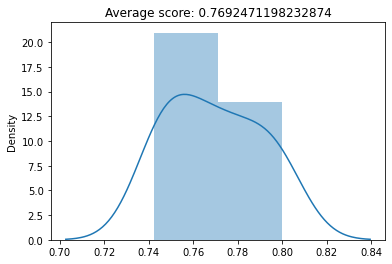

In [ ]:
sns.distplot(cv_scores)
plt.title("Average score: {}".format(np.mean(cv_scores)))

## Parameter Tuning with Grid Search

In [ ]:
dtc = DecisionTreeClassifier(random_state=RANDOM_STATE)
# Create the parameter grids
parameter_grid = {
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "max_depth": [2, 3, 4, 5, 6, 7, 8],
    "max_features": ["sqrt", "log2", None],
}

# Create Stratified folds
cross_validation = StratifiedKFold(n_splits=10)

# Create the scoring dictionary
SCORING = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "f1": "f1_macro",
}

# Create and fit the GridSearchCV
grid_search = GridSearchCV(
    estimator=dtc,
    param_grid=parameter_grid,
    cv=cross_validation,
    verbose=1,
    scoring=SCORING,
    return_train_score=True,
    refit="accuracy",
)

grid_search.fit(dt_dataset, target)
# grid_search.cv_results_

Fitting 10 folds for each of 84 candidates, totalling 840 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(random_state=3993),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8],
                         'max_features': ['sqrt', 'log2', None],
                         'splitter': ['best', 'random']},
             refit='accuracy', return_train_score=True,
             scoring={'accuracy': 'accuracy',
                      'balanced_accuracy': 'balanced_accuracy',
                      'f1': 'f1_macro'},
             verbose=1)

In [ ]:
print("Best score: {}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))

best_dtc = grid_search.best_estimator_
best_dtc

Best score: 0.7692471198232874
Best parameters: {'criterion': 'gini', 'max_depth': 4, 'max_features': None, 'splitter': 'best'}


DecisionTreeClassifier(max_depth=4, random_state=3993)

In [ ]:
best_dtc.fit(dt_dataset, target)
best_dtc.score(dt_dataset, target)

0.7724606004831474

In [ ]:
y_pred = best_dtc.predict(dt_dataset)
print("Confusion Matrix:")
print(confusion_matrix(target, y_pred))

print("Classification Report:")
print(classification_report(target, y_pred))

Confusion Matrix:
[[3074 1241]
 [ 737 3641]]
Classification Report:
              precision    recall  f1-score   support

       False       0.81      0.71      0.76      4315
        True       0.75      0.83      0.79      4378

    accuracy                           0.77      8693
   macro avg       0.78      0.77      0.77      8693
weighted avg       0.78      0.77      0.77      8693



In [ ]:
# The snippet below will retrieve the feature importances from the model and make them into a DataFrame.
feature_importances = pd.DataFrame(
    best_dtc.feature_importances_, index=dt_dataset.columns, columns=["importance"]
).sort_values("importance", ascending=False)
feature_importances

,importance
col9,0.545856
col3,0.115427
col4,0.100087
col16,0.075216
col2,0.075025
col5,0.027449
col23,0.019830
col8,0.012482
col18,0.010468
col6,0.007196


## Submission

In [ ]:
generateSubmission(
    best_dtc,
    model_preprocessor=dt_preprocessor,
    file_name="tuned_decis_tree.csv", 
    direct_submit_to_kaggle=False
)

     PassengerId  transported
0        0013_01         True
1        0018_01        False
2        0019_01         True
3        0021_01        False
4        0023_01         True
...          ...          ...
4272     9266_02         True
4273     9269_01         True
4274     9271_01         True
4275     9273_01        False
4276     9277_01         True

[4277 rows x 2 columns]


---
# Neural Networks

## Preprocessing

In [ ]:
nn_dataset = pp_dataset.copy()

### Numerizing features

In [ ]:
# Create categorical transformer (binary + nominal)
# Replace imputer
categorical_transformer = Pipeline(
    steps=[
        # ("one_hot_encoder", OneHotEncoder(sparse=False)), # the onehotencoder seems to not work good...
        ("ordinal_encoder", OrdinalEncoder()),
        ("scaler", StandardScaler()),
    ]
)

In [ ]:
# Create numeric transformer
# Impute missing values using the median value of each colum
numeric_transformer = Pipeline(
    steps=[
           ("scaler", StandardScaler())
    ]
)

In [ ]:
# Create the imputer of mixed type columns
# ATTENTION: the preprocessor can be used in a Pipeline for simplicity
numerizer = ColumnTransformer(
    transformers=[
        ("preproc_numeric", numeric_transformer, NUMERICAL_COLS),
        ("preproc_categorical", categorical_transformer, CATEGORICAL_COLS),
    ],
    verbose=True,
)


# Column names after mixed imputation procedure
COLUMN_NAMES = NUMERICAL_COLS + CATEGORICAL_COLS

In [ ]:
# Fit the imputer
numerizer.fit(nn_dataset)

numerizer = Pipeline(
    steps=[
           ("numerizer", numerizer),
           ("columns", array_to_dataframer(COLUMN_NAMES))
    ]
)

[ColumnTransformer]  (1 of 2) Processing preproc_numeric, total=   0.0s
[ColumnTransformer]  (2 of 2) Processing preproc_categorical, total=   0.1s


In [ ]:
nn_preprocessor = Pipeline(
    steps=[
           ("numerizer", numerizer),
          #  ("dropper", nn_column_dropper),
           ("sorter", columns_sorter)
    ]
)

nn_dataset = nn_preprocessor.transform(nn_dataset)
nn_dataset

,Age,CabinLetter,CabinNumber,CabinPS,CryoSleep,Destination,FoodCourt,HomePlanet,RoomService,ShoppingMall,Spa,VIP,VRDeck
0,0.705117,-1.883161,-1.191744,-1.032865,-0.732770,0.620545,-0.283565,0.440385,-0.338270,-0.287939,-0.273560,-0.153063,-0.265818
1,-0.338899,0.369299,-1.191744,0.968181,-0.732770,0.620545,-0.277930,-0.817259,-0.173619,-0.246165,0.213965,-0.153063,-0.227037
2,2.027537,-2.446276,-1.191744,0.968181,-0.732770,0.620545,1.955440,0.440385,-0.273316,-0.287939,5.689517,6.533255,-0.222630
3,0.287511,-2.446276,-1.191744,0.968181,-0.732770,0.620545,0.519747,0.440385,-0.338270,0.331980,2.682670,-0.153063,-0.095712
4,-0.895707,0.369299,-1.189769,0.968181,-0.732770,0.620545,-0.239736,-0.817259,0.119428,-0.035627,0.228174,-0.153063,-0.264055
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0.844319,-2.446276,-0.998198,-1.032865,-0.732770,-1.833685,3.985946,0.440385,-0.338270,-0.287939,1.185463,6.533255,-0.200596
8689,-0.756505,0.932414,1.768722,0.968181,1.364685,-0.606570,-0.283565,-0.817259,-0.338270,-0.287939,-0.273560,-0.153063,-0.265818
8690,-0.199696,0.932414,1.770697,0.968181,-0.732770,0.620545,-0.283565,-0.817259,-0.338270,2.840060,-0.272672,-0.153063,-0.265818
8691,0.217910,-0.193816,0.009032,0.968181,-0.732770,-1.833685,0.373235,0.440385,-0.338270,-0.287939,0.039913,-0.153063,2.585435


## Training

### Simple fixed NN

In [ ]:
def simple_nn_model(input_shape, hidden_units, hidden_activation="relu"):
  # Initialize the constructor
  model = Sequential()
  # Add an input layer
  hidden_units[0]
  model.add(Dense(hidden_units[0], activation=hidden_activation, input_shape=(input_shape,)))
  # Add one hidden layer
  model.add(Dense(hidden_units[1], activation=hidden_activation))
  # Add an output layer
  model.add(Dense(1, activation="sigmoid"))

  # Compile the model
  model.compile(
      loss="binary_crossentropy",
      optimizer="SGD",
      metrics=["accuracy", tf.keras.metrics.AUC()],
  )

  return model

In [ ]:
EPOCHS = 20
TRAIN_SIZE = 0.8
VAL_SIZE = 0.2
BATCH_SIZE = 32

In [ ]:
# Initialize the constructor
nn_model = simple_nn_model(input_shape=nn_dataset.columns.size, hidden_units=[10,10])

In [ ]:
training_phase = nn_model.fit(
    nn_dataset,
    target,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VAL_SIZE,
    verbose=1,
)

Epoch 1/20
218/218 [==============================] - 4s 11ms/step - loss: 0.6971 - accuracy: 0.4731 - auc: 0.4774 - val_loss: 0.6983 - val_accuracy: 0.4560 - val_auc: 0.4645
Epoch 2/20
218/218 [==============================] - 2s 9ms/step - loss: 0.6751 - accuracy: 0.5779 - auc: 0.6051 - val_loss: 0.6785 - val_accuracy: 0.5802 - val_auc: 0.5713
Epoch 3/20
218/218 [==============================] - 2s 8ms/step - loss: 0.6569 - accuracy: 0.6511 - auc: 0.6713 - val_loss: 0.6580 - val_accuracy: 0.6176 - val_auc: 0.6487
Epoch 4/20
218/218 [==============================] - 2s 8ms/step - loss: 0.6367 - accuracy: 0.6769 - auc: 0.7212 - val_loss: 0.6341 - val_accuracy: 0.6509 - val_auc: 0.7085
Epoch 5/20
218/218 [==============================] - 2s 8ms/step - loss: 0.6114 - accuracy: 0.6954 - auc: 0.7609 - val_loss: 0.6030 - val_accuracy: 0.6952 - val_auc: 0.7551
Epoch 6/20
218/218 [==============================] - 2s 8ms/step - loss: 0.5807 - accuracy: 0.7169 - auc: 0.7896 - val_loss: 0.5

loss


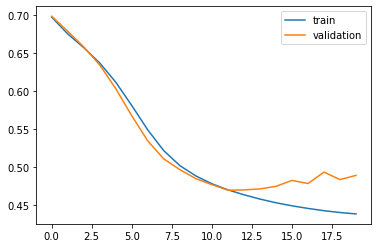

Accuracy


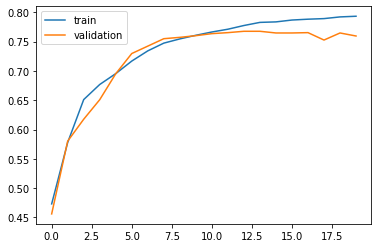

In [ ]:
# plot training history
print("loss")
plt.plot(training_phase.history["loss"], label="train")
plt.plot(training_phase.history["val_loss"], label="validation")
plt.legend()
plt.show()
print("Accuracy")
plt.plot(training_phase.history["accuracy"], label="train")
plt.plot(training_phase.history["val_accuracy"], label="validation")
plt.legend()
plt.show()

In [ ]:
y_pred = nn_model.predict(nn_dataset)
# We will look at the predicted Qualities to ensure we have something sensible.
y_pred = np.round(y_pred).astype(bool)
print(y_pred)

[[ True]
 [False]
 [False]
 ...
 [ True]
 [False]
 [ True]]


In [ ]:
print(confusion_matrix(target, y_pred))

print("Classification Report:")
print(classification_report(target, y_pred))

[[3230 1085]
 [ 765 3613]]
Classification Report:
              precision    recall  f1-score   support

       False       0.81      0.75      0.78      4315
        True       0.77      0.83      0.80      4378

    accuracy                           0.79      8693
   macro avg       0.79      0.79      0.79      8693
weighted avg       0.79      0.79      0.79      8693



In [ ]:
# generate a submission file
generateSubmission(
    model=nn_model,
    model_preprocessor=nn_preprocessor,
    model_postprocessor = FunctionTransformer(lambda y: np.round(y).astype(bool)),
    file_name="nn_basic.csv",
    direct_submit_to_kaggle=False
)

     PassengerId  transported
0        0013_01         True
1        0018_01        False
2        0019_01         True
3        0021_01         True
4        0023_01         True
...          ...          ...
4272     9266_02         True
4273     9269_01         True
4274     9271_01         True
4275     9273_01         True
4276     9277_01         True

[4277 rows x 2 columns]


#### Splitting in training and testing for validation

In [ ]:
x_train_pp_2, x_test_pp_2, y_train_2, y_test_2 = train_test_split(
    nn_dataset, target, train_size=TRAIN_SIZE, random_state=RANDOM_STATE
)

training_phase = nn_model.fit(
    x_train_pp_2,
    y_train_2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VAL_SIZE,
    verbose=1,
)

Epoch 1/20
174/174 [==============================] - 1s 8ms/step - loss: 0.4432 - accuracy: 0.7904 - auc: 0.8741 - val_loss: 0.4365 - val_accuracy: 0.7836 - val_auc: 0.8756
Epoch 2/20
174/174 [==============================] - 1s 8ms/step - loss: 0.4399 - accuracy: 0.7938 - auc: 0.8760 - val_loss: 0.4349 - val_accuracy: 0.7865 - val_auc: 0.8771
Epoch 3/20
174/174 [==============================] - 1s 7ms/step - loss: 0.4385 - accuracy: 0.7940 - auc: 0.8769 - val_loss: 0.4340 - val_accuracy: 0.7894 - val_auc: 0.8776
Epoch 4/20
174/174 [==============================] - 1s 8ms/step - loss: 0.4372 - accuracy: 0.7945 - auc: 0.8779 - val_loss: 0.4329 - val_accuracy: 0.7901 - val_auc: 0.8783
Epoch 5/20
174/174 [==============================] - 1s 8ms/step - loss: 0.4362 - accuracy: 0.7956 - auc: 0.8782 - val_loss: 0.4321 - val_accuracy: 0.7908 - val_auc: 0.8789
Epoch 6/20
174/174 [==============================] - 1s 8ms/step - loss: 0.4353 - accuracy: 0.7967 - auc: 0.8790 - val_loss: 0.43

loss


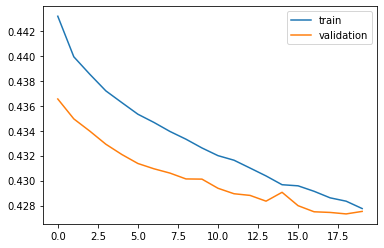

Accuracy


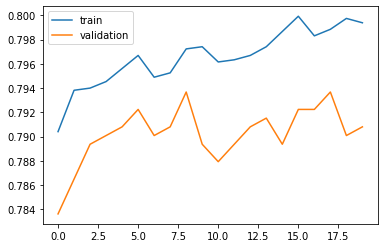

In [ ]:
# plot training history
print("loss")
plt.plot(training_phase.history["loss"], label="train")
plt.plot(training_phase.history["val_loss"], label="validation")
plt.legend()
plt.show()
print("Accuracy")
plt.plot(training_phase.history["accuracy"], label="train")
plt.plot(training_phase.history["val_accuracy"], label="validation")
plt.legend()
plt.show()

In [ ]:
# Performance on the training set
y_pred_2 = nn_model.predict(x_train_pp_2)
y_predicted_2 = np.round(y_pred_2).astype(int)
y_predicted_2 = np.squeeze(y_predicted_2)
#print(y_predicted_2.tolist())
print(confusion_matrix(y_train_2, y_predicted_2))

print("Classification Report:")
print(classification_report(y_train_2, y_predicted_2))

[[2648  807]
 [ 608 2891]]
Classification Report:
              precision    recall  f1-score   support

       False       0.81      0.77      0.79      3455
        True       0.78      0.83      0.80      3499

    accuracy                           0.80      6954
   macro avg       0.80      0.80      0.80      6954
weighted avg       0.80      0.80      0.80      6954



#### K-Fold cross validation

In [ ]:
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from scikeras.wrappers import KerasClassifier

keras_model_classifier = KerasClassifier(
    model=simple_nn_model,
    input_shape=nn_dataset.columns.size,
    hidden_units=(12, 6),
    hidden_activation="relu",
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VAL_SIZE,
    verbose=1,
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
145/145 [==============================] - 4s 13ms/step - loss: 0.7350 - accuracy: 0.5690 - auc_1: 0.5569 - val_loss: 0.6726 - val_accuracy: 0.5798 - val_auc_1: 0.6503
Epoch 2/20
145/145 [==============================] - 2s 14ms/step - loss: 0.6509 - accuracy: 0.6301 - auc_1: 0.6904 - val_loss: 0.6262 - val_accuracy: 0.6816 - val_auc_1: 0.7526
Epoch 3/20
145/145 [==============================] - 2s 16ms/step - loss: 0.6113 - accuracy: 0.6872 - auc_1: 0.7599 - val_loss: 0.5909 - val_accuracy: 0.7161 - val_auc_1: 0.7907
Epoch 4/20
145/145 [==============================] - 2s 14ms/step - loss: 0.5756 - accuracy: 0.7224 - auc_1: 0.7975 - val_loss: 0.5601 - val_accuracy: 0.7532 - val_auc_1: 0.8110
Epoch 5/20
145/145 [==============================] - 3s 20ms/step - loss: 0.5418 - accuracy: 0.7465 - auc_1: 0.8200 - val_loss: 0.5318 - val_accuracy: 0.7636 - val_auc_1: 0.8234
Epoch 6/20
145/145 [==============================] - 3s 21ms/step - loss: 0.5165 - accuracy: 0.7539 - au

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.1min finished
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Average score: 0.7726910087372936')

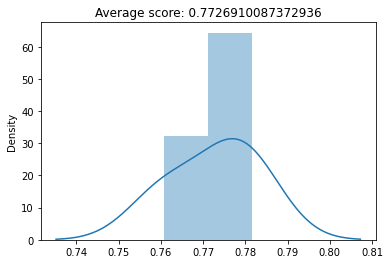

In [ ]:
SPLIT = 3
cv_scores = cross_val_score(
    keras_model_classifier, nn_dataset, target, cv=SPLIT, scoring="accuracy", verbose=1,
)
sns.distplot(cv_scores)
plt.title("Average score: {}".format(np.mean(cv_scores)))

In [ ]:
keras_model_classifier.fit(nn_dataset, target)
keras_model_classifier.score(nn_dataset, target)

Epoch 1/20
218/218 [==============================] - 6s 18ms/step - loss: 0.7191 - accuracy: 0.5211 - auc_4: 0.4984 - val_loss: 0.7023 - val_accuracy: 0.5158 - val_auc_4: 0.5244
Epoch 2/20
218/218 [==============================] - 4s 16ms/step - loss: 0.6725 - accuracy: 0.6399 - auc_4: 0.6321 - val_loss: 0.6683 - val_accuracy: 0.6429 - val_auc_4: 0.6398
Epoch 3/20
218/218 [==============================] - 4s 18ms/step - loss: 0.6520 - accuracy: 0.6723 - auc_4: 0.6796 - val_loss: 0.6494 - val_accuracy: 0.6774 - val_auc_4: 0.6855
Epoch 4/20
218/218 [==============================] - 4s 19ms/step - loss: 0.6334 - accuracy: 0.6956 - auc_4: 0.7123 - val_loss: 0.6312 - val_accuracy: 0.7033 - val_auc_4: 0.7165
Epoch 5/20
218/218 [==============================] - 3s 13ms/step - loss: 0.6133 - accuracy: 0.7118 - auc_4: 0.7405 - val_loss: 0.6101 - val_accuracy: 0.7217 - val_auc_4: 0.7442
Epoch 6/20
218/218 [==============================] - 4s 18ms/step - loss: 0.5911 - accuracy: 0.7252 - au

0.7908662141953295

### Grid Search Parameter Tuning

In every classification technique, there are some parameters that can be tuned to optimize the classification. Some parameters that can be tuned in the decision tree is max depth (the depth of the tree), max feature (the feature used to classify), criterion, and splitter.

To search to tune parameter is to use Grid Search. Basically, it explores a range of parameters and finds the best combination of parameters. Then repeat the process several times until the best parameters are discovered. We will also use Stratified k-fold cross-validation that will prevent a certain class only split them to the same subset.

In [ ]:
# Create the parameter grids
parameter_grid = {
    "hidden_units": [(10,10),(20,20)], ## (40,40)],
    "hidden_activation": ["relu"], #], "tanh"],
    "epochs": [10, 20, 30],
    "batch_size": [1, 32], # 64],
    "verbose": [0],
}

# Create Stratified folds
cross_validation = StratifiedKFold(n_splits=6)
cross_validation.get_n_splits(nn_dataset, target)

# Create the scoring dictionary
SCORING = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "f1": "f1_macro",
}

# Create and fit the GridSearchCV
grid_search = GridSearchCV(
    estimator=keras_model_classifier,
    param_grid=parameter_grid,
    cv=cross_validation,
    verbose=1,
    scoring=SCORING,
    return_train_score=False,  # True,
    refit="accuracy",
)

# You can use X_train without manual preprocessing because preprocessor is built-in the classifier pipeline
grid_search.fit(nn_dataset, target)

Fitting 6 folds for each of 12 candidates, totalling 72 fits


In [ ]:
# grid_search.cv_results_

In [ ]:
print("Best score: {}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))

best_nn = grid_search.best_estimator_
best_nn

```
Best score: 0.790518672304644
Best parameters: {'batch_size': 1, 'epochs': 30, 'hidden_activation': 'relu', 'hidden_units': (40, 40), 'verbose': 0}
KerasClassifier(
	model=<function simple_nn_model at 0x7fb6d58c80e0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=1
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=30
	input_shape=13
	hidden_units=(40, 40)
	hidden_activation=relu
	class_weight=None
)
```



In [ ]:
best_nn = KerasClassifier(
    model=simple_nn_model,
    build_fn=None,
    warm_start=False,
    random_state=None,
    optimizer="rmsprop",
    loss=None,
    metrics=None,
    batch_size=1,
    validation_batch_size=None,
    verbose=0,
    callbacks=None,
    validation_split=0.2,
    shuffle=True,
    run_eagerly=False,
    epochs=30,
    input_shape=13,
    hidden_units=(40, 40),
    hidden_activation="relu",
    class_weight=None
)
best_nn.fit(nn_dataset,target)

KerasClassifier(
	model=<function simple_nn_model at 0x7fe0bde09b00>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=1
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=30
	input_shape=13
	hidden_units=(40, 40)
	hidden_activation=relu
	class_weight=None
)

In [ ]:
y_pred = best_nn.predict(nn_dataset)
print("Confusion Matrix:")
print(confusion_matrix(target, y_pred))

print("Classification Report:")
print(classification_report(target, y_pred))

Confusion Matrix:
[[3579  736]
 [ 716 3662]]
Classification Report:
              precision    recall  f1-score   support

       False       0.83      0.83      0.83      4315
        True       0.83      0.84      0.83      4378

    accuracy                           0.83      8693
   macro avg       0.83      0.83      0.83      8693
weighted avg       0.83      0.83      0.83      8693



### Submit the final model

In [ ]:
# generate a submission file
generateSubmission(
    model=best_nn,
    model_preprocessor = nn_preprocessor,
    model_postprocessor = FunctionTransformer(lambda y: np.round(y).astype(bool)),
    file_name="best_NN.csv",
    direct_submit_to_kaggle=False
)

---
# SVM

## Preprocessing


In [ ]:
svm_dataset = pp_dataset.copy()

In [ ]:
# Create categorical transformer (binary + nominal)
categorical_transformer = Pipeline(
    steps=[
        ("one_hot_encoder", OneHotEncoder(sparse=False)),
        # ("ordinal_encoder", OrdinalEncoder()),
        ("scaler", StandardScaler()),
    ]
)

In [ ]:
# Create numeric transformer
numeric_transformer = Pipeline(
    steps=[
           ("scaler", StandardScaler())
    ]
)

In [ ]:
# Create the transformer of mixed type columns
numerizer = ColumnTransformer(
    transformers=[
        ("preproc_numeric", numeric_transformer, NUMERICAL_COLS),
        ("preproc_categorical", categorical_transformer, CATEGORICAL_COLS),
    ],
    verbose=True,
)


In [ ]:
# Fit the column transformer
numerizer.fit(svm_dataset)

numerizer = Pipeline(
    steps=[
           ("numerizer", numerizer),
           ("columns", array_to_dataframer())
    ]
)

[ColumnTransformer]  (1 of 2) Processing preproc_numeric, total=   0.0s
[ColumnTransformer]  (2 of 2) Processing preproc_categorical, total=   0.0s


In [ ]:
svm_preprocessor = Pipeline(
    steps=[
           ("numerizer", numerizer),
          #  ("dropper", dt_column_dropper),
          #  ("sorter", columns_sorter)
    ]
)

svm_dataset = svm_preprocessor.transform(svm_dataset)

## Training

In [ ]:
svmc = SVC(random_state=RANDOM_STATE)

C_values=[0.1, 1, 10]
# Create the parameter grids
parameter_grid = [{
    "C": C_values,
    "kernel": ["linear"],
}, 
{
    "C": C_values,
    "kernel": ["poly"],
    "degree": [2,3]
},
{
    "C": C_values,
    "kernel": ["rbf"],
    "gamma": [0.1,1,5]
}]

# Create Stratified folds
cross_validation = StratifiedKFold(n_splits=5)

# Create the scoring dictionary
SCORING = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "f1": "f1_macro",
}

# Create and fit the GridSearchCV
grid_search = GridSearchCV(
    estimator=svmc,
    param_grid=parameter_grid,
    cv=cross_validation,
    verbose=1,
    scoring=SCORING,
    return_train_score=True,
    refit="accuracy",
)

grid_search.fit(svm_dataset, target)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SVC(random_state=3993),
             param_grid=[{'C': [0.1, 1, 10], 'kernel': ['linear']},
                         {'C': [0.1, 1, 10], 'degree': [2, 3],
                          'kernel': ['poly']},
                         {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 5],
                          'kernel': ['rbf']}],
             refit='accuracy', return_train_score=True,
             scoring={'accuracy': 'accuracy',
                      'balanced_accuracy': 'balanced_accuracy',
                      'f1': 'f1_macro'},
             verbose=1)

```
SVC(C=10, kernel='linear', random_state=3993)
```

In [ ]:
print("Best score: {}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))

best_svmc = grid_search.best_estimator_
best_svmc

Best score: 0.789831993440935
Best parameters: {'C': 10, 'kernel': 'linear'}


SVC(C=10, kernel='linear', random_state=3993)

In [ ]:
y_pred = best_svmc.predict(svm_dataset)
print("Confusion Matrix:")
print(confusion_matrix(target, y_pred))

print("Classification Report:")
print(classification_report(target, y_pred))

Confusion Matrix:
[[3397  918]
 [ 868 3510]]
Classification Report:
              precision    recall  f1-score   support

       False       0.80      0.79      0.79      4315
        True       0.79      0.80      0.80      4378

    accuracy                           0.79      8693
   macro avg       0.79      0.79      0.79      8693
weighted avg       0.79      0.79      0.79      8693



---
# Ensemble Methods

## Preprocessing

In [31]:
ens_dataset = pp_dataset.copy()

In [32]:
# Create categorical transformer (binary + nominal)
categorical_transformer = Pipeline(
    steps=[
        ("one_hot_encoder", OneHotEncoder(sparse=False)),
        # ("ordinal_encoder", OrdinalEncoder()),
        ("scaler", StandardScaler()),
    ]
)

In [33]:
# Create numeric transformer
numeric_transformer = Pipeline(
    steps=[
           ("scaler", StandardScaler())
    ]
)

In [34]:
# Create the transformer of mixed type columns
numerizer = ColumnTransformer(
    transformers=[
        ("preproc_numeric", numeric_transformer, NUMERICAL_COLS),
        ("preproc_categorical", categorical_transformer, CATEGORICAL_COLS),
    ],
    verbose=True,
)

In [35]:
# Fit the column transformer
numerizer.fit(ens_dataset)

numerizer = Pipeline(
    steps=[
           ("numerizer", numerizer),
           ("columns", array_to_dataframer())
    ]
)

[ColumnTransformer]  (1 of 2) Processing preproc_numeric, total=   0.0s
[ColumnTransformer]  (2 of 2) Processing preproc_categorical, total=   0.0s


In [36]:
ens_preprocessor = Pipeline(
    steps=[
           ("numerizer", numerizer),
          #  ("dropper", dt_column_dropper),
          #  ("sorter", columns_sorter)
    ]
)

ens_dataset = ens_preprocessor.transform(ens_dataset)

## Training

Voting Classifier

In [ ]:
from sklearn.ensemble import VotingClassifier

votc = VotingClassifier(
    estimators=[('dt', best_dtc), ('svm', best_svmc )],
    voting='hard')
votc.fit(ens_dataset, target)

xtr, xte, ytr, yte = train_test_split(ens_dataset, target)

votc.fit(xtr, ytr)
votc.score(xte, yte)

Bagging Classifier

In [59]:
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(max_depth=10), random_state=RANDOM_STATE)

# Create the parameter grids
parameter_grid = {
    "n_estimators": [50,100,200],
}

# Create Stratified folds
cross_validation = StratifiedKFold(n_splits=10)

# Create the scoring dictionary
SCORING = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "f1": "f1_macro",
}

# Create and fit the GridSearchCV
grid_search = GridSearchCV(
    estimator=bag_clf,
    param_grid=parameter_grid,
    cv=cross_validation,
    verbose=1,
    scoring=SCORING,
    return_train_score=True,
    refit="accuracy",
)

grid_search.fit(ens_dataset, target)


Fitting 10 folds for each of 3 candidates, totalling 30 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),
                                         random_state=3993),
             param_grid={'n_estimators': [50, 100, 200]}, refit='accuracy',
             return_train_score=True,
             scoring={'accuracy': 'accuracy',
                      'balanced_accuracy': 'balanced_accuracy',
                      'f1': 'f1_macro'},
             verbose=1)

```
BaggingClassifier(n_estimators=50, random_state=3993)
```

In [60]:
print("Best score: {}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))

best_bag = grid_search.best_estimator_
best_bag

Best score: 0.7800607118765129
Best parameters: {'n_estimators': 50}


BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),
                  n_estimators=50, random_state=3993)

In [61]:
y_pred = best_bag.predict(ens_dataset)
print("Confusion Matrix:")
print(confusion_matrix(target, y_pred))

print("Classification Report:")
print(classification_report(target, y_pred))

Confusion Matrix:
[[3814  501]
 [ 551 3827]]
Classification Report:
              precision    recall  f1-score   support

       False       0.87      0.88      0.88      4315
        True       0.88      0.87      0.88      4378

    accuracy                           0.88      8693
   macro avg       0.88      0.88      0.88      8693
weighted avg       0.88      0.88      0.88      8693



Pasting Classifier

In [62]:
pas_clf = BaggingClassifier(DecisionTreeClassifier(max_depth=10), random_state=RANDOM_STATE, bootstrap=False, max_samples=2000)

# Create the parameter grids
parameter_grid = {
    "n_estimators": [50,100,200],
}

# Create Stratified folds
cross_validation = StratifiedKFold(n_splits=10)

# Create the scoring dictionary
SCORING = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "f1": "f1_macro",
}

# Create and fit the GridSearchCV
grid_search = GridSearchCV(
    estimator=pas_clf,
    param_grid=parameter_grid,
    cv=cross_validation,
    verbose=1,
    scoring=SCORING,
    return_train_score=True,
    refit="accuracy",
)

grid_search.fit(ens_dataset, target)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),
                                         bootstrap=False, max_samples=2000,
                                         random_state=3993),
             param_grid={'n_estimators': [50, 100, 200]}, refit='accuracy',
             return_train_score=True,
             scoring={'accuracy': 'accuracy',
                      'balanced_accuracy': 'balanced_accuracy',
                      'f1': 'f1_macro'},
             verbose=1)

```
BaggingClassifier(n_estimators=100, random_state=3993)
```

In [64]:
print("Best score: {}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))

best_pas = grid_search.best_estimator_
best_pas

Best score: 0.7805207465312223
Best parameters: {'n_estimators': 100}


BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),
                  bootstrap=False, max_samples=2000, n_estimators=100,
                  random_state=3993)

In [65]:
y_pred = best_pas.predict(ens_dataset)
print("Confusion Matrix:")
print(confusion_matrix(target, y_pred))

print("Classification Report:")
print(classification_report(target, y_pred))

Confusion Matrix:
[[3687  628]
 [ 662 3716]]
Classification Report:
              precision    recall  f1-score   support

       False       0.85      0.85      0.85      4315
        True       0.86      0.85      0.85      4378

    accuracy                           0.85      8693
   macro avg       0.85      0.85      0.85      8693
weighted avg       0.85      0.85      0.85      8693



Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(random_state=RANDOM_STATE)

# Create the parameter grids
parameter_grid = {
    "n_estimators": [100,200,500],
    "criterion": ["gini", "entropy"],
    "max_features": ["sqrt", "log2"]
}

# Create Stratified folds
cross_validation = StratifiedKFold(n_splits=10)

# Create the scoring dictionary
SCORING = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "f1": "f1_macro",
}

# Create and fit the GridSearchCV
grid_search = GridSearchCV(
    estimator=rnd_clf,
    param_grid=parameter_grid,
    cv=cross_validation,
    verbose=1,
    scoring=SCORING,
    return_train_score=True,
    refit="accuracy",
)

grid_search.fit(ens_dataset, target)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=3993),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 200, 500]},
             refit='accuracy', return_train_score=True,
             scoring={'accuracy': 'accuracy',
                      'balanced_accuracy': 'balanced_accuracy',
                      'f1': 'f1_macro'},
             verbose=1)

```
RandomForestClassifier(criterion='entropy', n_estimators=500, max_features="sqrt", random_state=3993)
```

In [39]:
print("Best score: {}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))

best_rnd = grid_search.best_estimator_
best_rnd

Best score: 0.790870864912768
Best parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 500}


RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       n_estimators=500, random_state=3993)

In [40]:
y_pred = best_rnd.predict(ens_dataset)
print("Confusion Matrix:")
print(confusion_matrix(target, y_pred))

print("Classification Report:")
print(classification_report(target, y_pred))

Confusion Matrix:
[[4310    5]
 [   1 4377]]
Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      4315
        True       1.00      1.00      1.00      4378

    accuracy                           1.00      8693
   macro avg       1.00      1.00      1.00      8693
weighted avg       1.00      1.00      1.00      8693



Extra Trees

In [66]:
from sklearn.ensemble import ExtraTreesClassifier

ext_clf = ExtraTreesClassifier(random_state=RANDOM_STATE)

# Create the parameter grids
parameter_grid = {
    "n_estimators": [100,200,500, 700, 1000],
    "criterion": ["gini", "entropy"],
    "max_features": ["sqrt", "log2"]
}

# Create Stratified folds
cross_validation = StratifiedKFold(n_splits=10)

# Create the scoring dictionary
SCORING = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "f1": "f1_macro",
}

# Create and fit the GridSearchCV
grid_search = GridSearchCV(
    estimator=ext_clf,
    param_grid=parameter_grid,
    cv=cross_validation,
    verbose=1,
    scoring=SCORING,
    return_train_score=True,
    refit="accuracy",
)

grid_search.fit(ens_dataset, target)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=ExtraTreesClassifier(random_state=3993),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 200, 500, 700, 1000]},
             refit='accuracy', return_train_score=True,
             scoring={'accuracy': 'accuracy',
                      'balanced_accuracy': 'balanced_accuracy',
                      'f1': 'f1_macro'},
             verbose=1)

```
ExtraTreesClassifier(criterion='entropy', max_features='sqrt', n_estimators=200, random_state=3993)
```

In [67]:
print("Best score: {}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))

best_ext = grid_search.best_estimator_
best_ext

Best score: 0.7882244090842956
Best parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 200}


ExtraTreesClassifier(criterion='entropy', max_features='sqrt', n_estimators=200,
                     random_state=3993)

In [68]:
y_pred = best_ext.predict(ens_dataset)
print("Confusion Matrix:")
print(confusion_matrix(target, y_pred))

print("Classification Report:")
print(classification_report(target, y_pred))

Confusion Matrix:
[[4314    1]
 [   5 4373]]
Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      4315
        True       1.00      1.00      1.00      4378

    accuracy                           1.00      8693
   macro avg       1.00      1.00      1.00      8693
weighted avg       1.00      1.00      1.00      8693



Adaboost

In [53]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),random_state=RANDOM_STATE)

# Create the parameter grids
parameter_grid = {
    "n_estimators": [50,100,500],
    "learning_rate": [0.2, 0.5, 1],
    "algorithm": ["SAMME", "SAMME.R"]
    
}

# Create Stratified folds
cross_validation = StratifiedKFold(n_splits=10)

# Create the scoring dictionary
SCORING = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "f1": "f1_macro",
}

# Create and fit the GridSearchCV
grid_search = GridSearchCV(
    estimator=ada_clf,
    param_grid=parameter_grid,
    cv=cross_validation,
    verbose=1,
    scoring=SCORING,
    return_train_score=True,
    refit="accuracy",
)

grid_search.fit(ens_dataset, target)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),
                                          random_state=3993),
             param_grid={'algorithm': ['SAMME.R'],
                         'base_estimator__max_depth': [1, 5],
                         'learning_rate': [0.2, 0.5, 1],
                         'n_estimators': [50, 100]},
             refit='accuracy', return_train_score=True,
             scoring={'accuracy': 'accuracy',
                      'balanced_accuracy': 'balanced_accuracy',
                      'f1': 'f1_macro'},
             verbose=1)

```
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=50, algorithm="SAMME.R" random_state=3993)

```

In [55]:
print("Best score: {}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))

best_ada = grid_search.best_estimator_
best_ada

Best score: 0.7936319987302092
Best parameters: {'algorithm': 'SAMME.R', 'base_estimator__max_depth': 1, 'learning_rate': 0.5, 'n_estimators': 50}


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, random_state=3993)

In [52]:
y_pred = best_ext.predict(ens_dataset)
print("Confusion Matrix:")
print(confusion_matrix(target, y_pred))

print("Classification Report:")
print(classification_report(target, y_pred))

Confusion Matrix:
[[4314    1]
 [   5 4373]]
Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      4315
        True       1.00      1.00      1.00      4378

    accuracy                           1.00      8693
   macro avg       1.00      1.00      1.00      8693
weighted avg       1.00      1.00      1.00      8693



XGBoost

In [ ]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(ens_dataset, target)
xgb_clf.score(ens_dataset, target)


xtr, xte, ytr, yte = train_test_split(ens_dataset, target)

xgb_clf.fit(xtr, ytr)
xgb_clf.score(xte, yte)

     PassengerId  transported
0        0013_01         True
1        0018_01        False
2        0019_01         True
3        0021_01         True
4        0023_01         True
...          ...          ...
4272     9266_02         True
4273     9269_01        False
4274     9271_01         True
4275     9273_01         True
4276     9277_01         True

[4277 rows x 2 columns]


In [ ]:
generateSubmission(
    xgb_clf,
    model_preprocessor = ens_preprocessor,
    file_name="xgboost.csv",
    direct_submit_to_kaggle=False    
)

---
# Auto Sklearn

## Imports

In [ ]:
# sometimes you have to run this cell twice on colab
# !apt-get install swig -y
# !pip install Cython numpy
# !pip install scikit-learn --upgrade
!pip install auto-sklearn --upgrade
!pip install dask distributed --upgrade
# !pip install pipelineprofiler

#restart runtime
import os
os.kill(os.getpid(), 9)

## Dataset Preprocessing (just using the same as NN)

In [ ]:
auto_preprocessor = nn_preprocessor
auto_dataset = nn_dataset

## Training

In [ ]:
from autosklearn.classification import AutoSklearnClassifier
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics

X_train, X_test, y_train, y_test = \
        sklearn.model_selection.train_test_split(auto_dataset, target, random_state=1)

automl = AutoSklearnClassifier(time_left_for_this_task=60*5) #Auto-sklearn searches pipelines for 5 minutes; use ensemble_size=1 for a single model

automl.fit(X_train, y_train)

y_hat = automl.predict(X_test)

print("Accuracy score", sklearn.metrics.accuracy_score(y_test, y_hat))

In [ ]:
print(automl.sprint_statistics())

In [ ]:
print(automl.leaderboard())

In [ ]:
automl.show_models()

In [ ]:
# import PipelineProfiler

# data = PipelineProfiler.import_autosklearn(automl)
# PipelineProfiler.plot_pipeline_matrix(data)

## Submission

In [ ]:
# generate a submission file
generateSubmission(
    model=automl,
    model_preprocessor = auto_preprocessor,
    model_postprocessor = FunctionTransformer(lambda y: np.round(y).astype(bool)),
    file_name="automl.csv",
    direct_submit_to_kaggle=False
)